# Phytoplankton - El Niño

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import os
import os.path as op
import sys

import pandas as pd
import numpy as np
import geopandas as gpd
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

sys.path.append("../../../../indicators_setup")
from ind_setup.plotting_int import plot_timeseries_interactive, plot_oni_index_th
from ind_setup.plotting import plot_base_map, plot_map_subplots
from ind_setup.core import fontsize

sys.path.append("../../../functions")
from data_downloaders import download_ERDDAP_data, download_oni_index


Define area of interest

In [3]:
#Area of interest
lon_range  = [129.4088, 137.0541]
lat_range = [1.5214, 11.6587]

EEZ shapefile

In [4]:
shp_f = op.join(os.getcwd(), '..', '..','..', 'data/Palau_EEZ/pw_eez_pol_april2022.shp')
shp_eez = gpd.read_file(shp_f)

## Download Data

DATASET: https://oceanwatch.pifsc.noaa.gov/erddap/info/md50_exp/index.html


In [5]:
base_url = 'https://oceanwatch.pifsc.noaa.gov/erddap/griddap/md50_exp.csv'
dataset_id = 'MD50'
date_ini = '1998-01-01T00:00:00Z'
date_end = '2023-12-01T00:00:00Z'

data = download_ERDDAP_data(base_url, dataset_id, date_ini, date_end, lon_range, lat_range)

In [6]:
data_xr = data.set_index(['latitude', 'longitude', 'time']).to_xarray()
data_xr['time'] = pd.to_datetime(data_xr.time)
data_xr = data_xr.coarsen(longitude=2, latitude=2).mean()

In [7]:
p_data = 'https://psl.noaa.gov/data/correlation/oni.data'
df1 = download_oni_index(p_data)

In [8]:
lims = [-.5, .5]
plot_oni_index_th(df1, lims = lims)

In [9]:
data_xr['ONI'] = (('time'), df1.iloc[np.intersect1d(data_xr.time, df1.index, return_indices=True)[2]].ONI.values)

In [10]:
data_xr['ONI_cat'] = (('time'), np.where(data_xr.ONI < lims[0], -1, np.where(data_xr.ONI > lims[1], 1, 0)))

In [11]:
data_oni = data_xr.groupby('ONI_cat').mean()

In [12]:
data_oni.isel(ONI_cat=0).ONI_cat.values

array(-1)

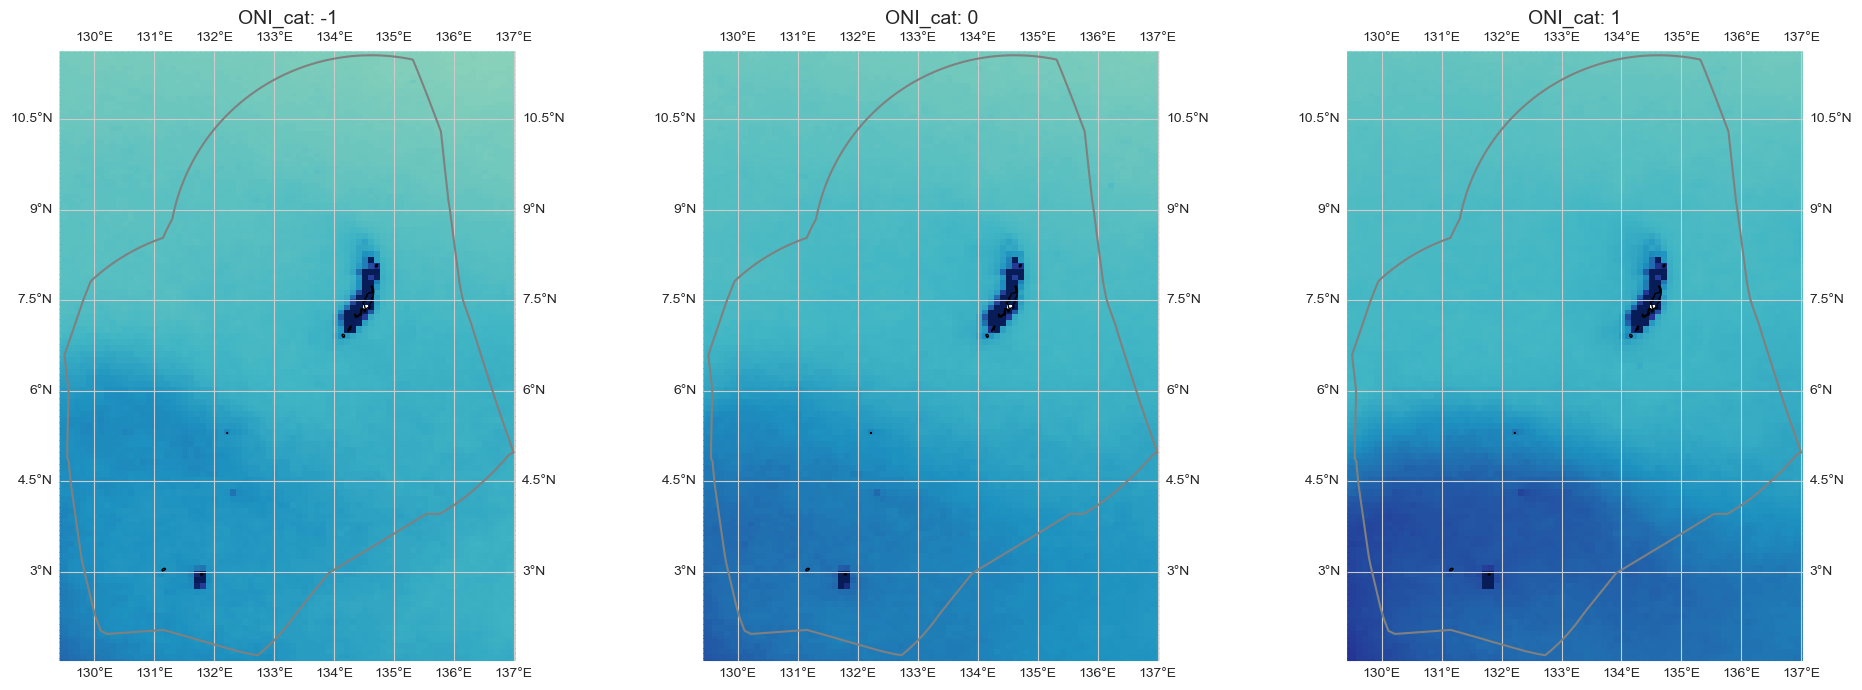

In [13]:
plot_map_subplots(data_oni, dataset_id, shp_eez = shp_eez, cmap = 'YlGnBu', vmin = 0.4, vmax = 1.6, 
                  sub_plot= [1, 3], figsize = (20, 7))

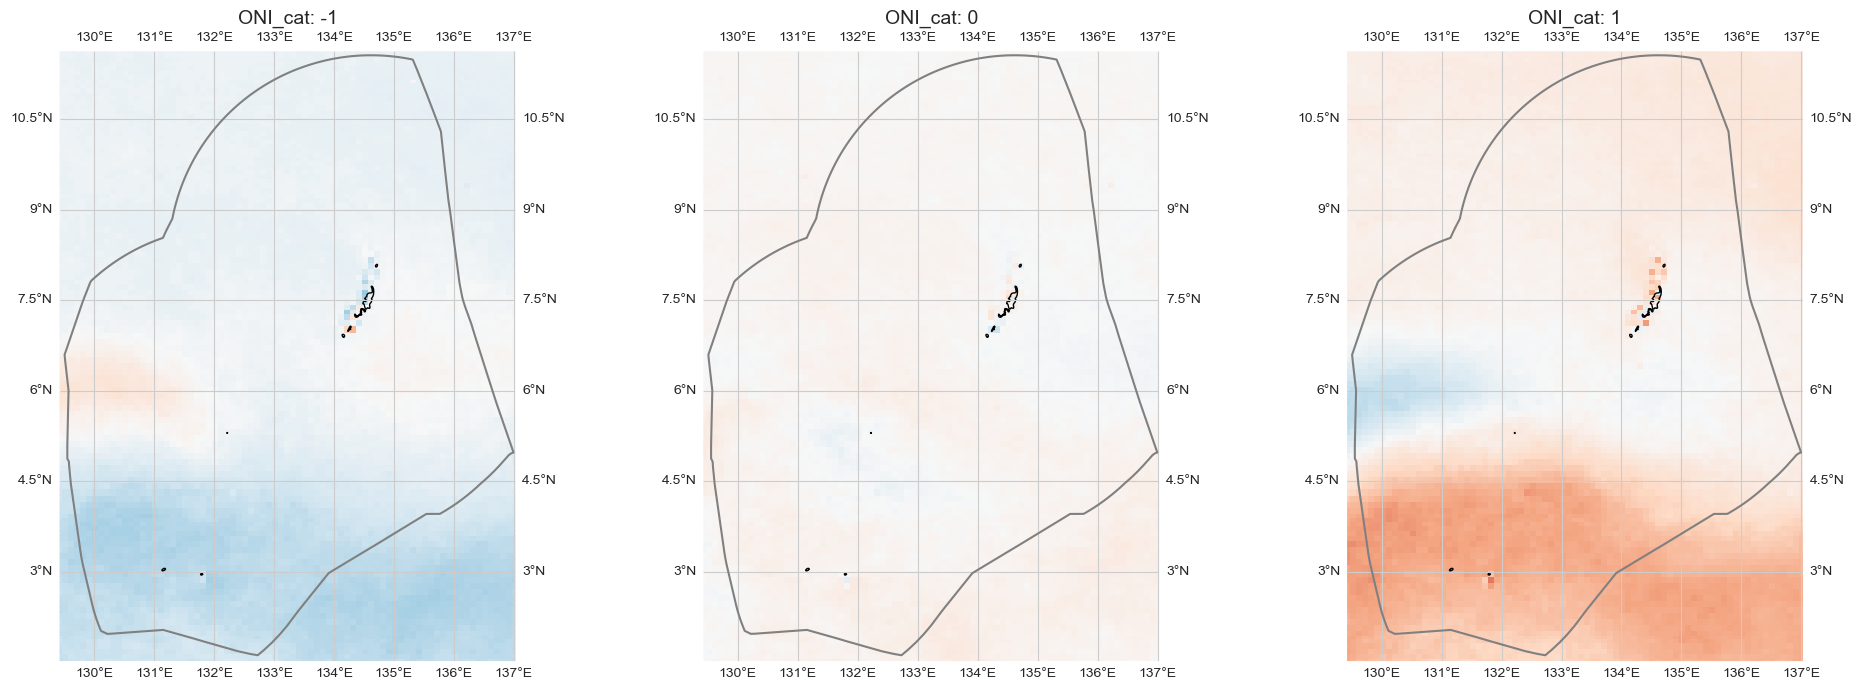

In [14]:
data_an = data_oni - data_xr.mean(dim='time')
plot_map_subplots(data_an, dataset_id, shp_eez = shp_eez, cmap='RdBu_r', vmin=-.3, vmax=.3,
                  sub_plot= [1, 3], figsize = (20, 7))